#Import libary yang dibutuhkan

In [2]:
# pip install lightfm

In [3]:
import pandas as pd
from lightfm import LightFM
from lightfm.data import Dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import precision_at_k, auc_score
from IPython.display import Image, display
import warnings
warnings.filterwarnings('ignore')



# Data wrangling

## Gathering Data

In [132]:
df_ratings = pd.read_csv('Ratings.csv')
df_books = pd.read_csv('Books.csv')
df_users = pd.read_csv('Users.csv')


print(df_users.shape)
print(df_books.shape)
print(df_ratings.shape)


<ipython-input-132-5c4657d05cbb>:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_books = pd.read_csv('Books.csv')


(278858, 3)
(271360, 8)
(1149780, 3)


## Assessing Data

In [133]:

print("\n--- Info Users ---")
print(df_users.info())
print("\n--- Missing Users ---")
print(df_users.isnull().sum())


--- Info Users ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB
None

--- Missing Users ---
User-ID          0
Location         0
Age         110762
dtype: int64


Dataset: Users
Jumlah total entri: 278.858 pengguna.

Kolom Age (usia) memiliki 110.762 missing values, atau sekitar 39.7% dari total data.

Usia disimpan sebagai float, tapi seharusnya bisa dikonversi ke int setelah pembersihan.

Tidak ada missing value untuk kolom User-ID dan Location.


In [134]:
print("\n--- Info Books ---")
print(df_books.info())
print("\n--- Missing Books ---")
print(df_books.isnull().sum())


--- Info Books ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB
None

--- Missing Books ---
ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64


Dataset: Books

Jumlah entri: 271.360 buku.

Kolom Book-Author dan Publisher memiliki 2 missing values masing-masing.

Kolom Image-URL-L (gambar ukuran besar) memiliki 3 missing values.

Semua kolom bertipe object, termasuk Year-Of-Publication yang seharusnya bertipe numerik.


In [135]:
print("\n--- Info Ratings ---")
print(df_ratings.info())
print("\n--- Missing Ratings ---")
print(df_ratings.isnull().sum())


--- Info Ratings ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB
None

--- Missing Ratings ---
User-ID        0
ISBN           0
Book-Rating    0
dtype: int64



Dataset: Ratings

Jumlah entri: 1.149.780 rating buku dari pengguna.

Tidak ada missing value.

Book-Rating bernilai antara 0–10, di mana 0 menunjukkan rating implisit (misalnya, user melihat buku tapi tidak memberikan penilaian eksplisit).

## Cleaning Dataset

In [136]:
df_books = df_books.dropna(subset=['Book-Author', 'Publisher', 'Image-URL-L'])
df_books.isnull().sum()


,0
ISBN,0
Book-Title,0
Book-Author,0
Year-Of-Publication,0
Publisher,0
Image-URL-S,0
Image-URL-M,0
Image-URL-L,0


 1. Filter data rating yang bernilai > 0 (artinya rating valid, bukan nol atau kosong)

In [137]:

df_ratings = df_ratings[df_ratings['Book-Rating'] > 0]

df_ratings.shape

(433671, 3)

Filter user yang aktif: user yang punya lebih dari 100 rating

In [138]:

user_counts = df_ratings['User-ID'].value_counts()
active_users = user_counts[user_counts > 100].index
df_ratings = df_ratings[df_ratings['User-ID'].isin(active_users)]

df_ratings.shape

(116945, 3)

In [139]:

book_counts = df_ratings['ISBN'].value_counts()
popular_books = book_counts[book_counts > 10].index
df_ratings = df_ratings[df_ratings['ISBN'].isin(popular_books)]
df_ratings.shape

(8516, 3)

In [140]:
interactions = df_ratings

Data Cleaning

In [141]:
# Bersihkan dataset books dari missing values
print(f" Books sebelum cleaning: {df_books.shape}")
df_books = df_books.dropna(subset=['Book-Author', 'Publisher', 'Image-URL-L'])
print(f" Books setelah cleaning: {df_books.shape}")
print(f" Berhasil menghapus {df_books.shape[0]} baris dengan missing values")

📚 Books sebelum cleaning: (271353, 8)
📚 Books setelah cleaning: (271353, 8)
✅ Berhasil menghapus 271353 baris dengan missing values


In [142]:
print("=" * 80)
print("SUMMARY DATA SETELAH CLEANING")
print("=" * 80)

print(f" Jumlah Users Aktif: {df_ratings['User-ID'].nunique()}")
print(f" Jumlah Books Populer: {df_ratings['ISBN'].nunique()}")
print(f" Total Interactions: {len(df_ratings)}")
print(f" Rata-rata Rating: {df_ratings['Book-Rating'].mean():.2f}")
print(f" Sparsity: {(1 - len(df_ratings) / (df_ratings['User-ID'].nunique() * df_ratings['ISBN'].nunique())) * 100:.2f}%")

SUMMARY DATA SETELAH CLEANING
 Jumlah Users Aktif: 460
 Jumlah Books Populer: 515
 Total Interactions: 8516
 Rata-rata Rating: 8.03
 Sparsity: 96.41%


# INISIALISASI DATASET LIGHTFM

In [143]:
dataset = Dataset()

dataset.fit(
    users=df_ratings['User-ID'].unique(),
    items=df_ratings['ISBN'].unique()
)

print(f" Dataset LightFM berhasil diinisialisasi")
print(f" Jumlah users: {len(df_ratings['User-ID'].unique())}")
print(f" Jumlah items: {len(df_ratings['ISBN'].unique())}")


 Dataset LightFM berhasil diinisialisasi
 Jumlah users: 460
 Jumlah items: 515


In [144]:
valid_isbns = set(df_ratings['ISBN'].unique())
df_books = df_books[df_books['ISBN'].isin(valid_isbns)].copy()
print(f"📚 Books dataset after filtering: {len(df_books)} books")

📚 Books dataset after filtering: 513 books


## Persiapan Item Features untuk Hybrid Model

In [145]:
all_features = set()

for _, row in df_books.iterrows():
    features = [
        f"title:{row['Book-Title']}",
        f"author:{row['Book-Author']}",
        f"publisher:{row['Publisher']}"
    ]
    all_features.update(features)

In [146]:
print(f" Total unique features: {len(all_features)}")

 Total unique features: 854


In [147]:
# Fit item features ke dataset
dataset.fit_partial(item_features=list(all_features))
print(" Item features berhasil di-fit ke dataset")

 Item features berhasil di-fit ke dataset


Build interaction matrix dengan rating sebagai weight

In [148]:
interactions, weights = dataset.build_interactions([
    (row['User-ID'], row['ISBN'], row['Book-Rating'])
    for _, row in df_ratings.iterrows()
])

print(f" Interaction matrix shape: {interactions.shape}")
print(f" Total interactions: {interactions.nnz}")
print(f" Density: {(interactions.nnz / (interactions.shape[0] * interactions.shape[1])) * 100:.4f}%")

 Interaction matrix shape: (460, 515)
 Total interactions: 8516
 Density: 3.5948%


# Build item features matrix untuk hybrid model

In [149]:
valid_isbns = set(df_ratings['ISBN'].unique())
print(f" Valid ISBNs in ratings: {len(valid_isbns)}")
print(f" ISBNs in books dataset: {len(df_books['ISBN'].unique())}")

df_books_filtered = df_books[df_books['ISBN'].isin(valid_isbns)].copy()
print(f" Books after filtering: {len(df_books_filtered)}")

item_features_data = []
for _, row in df_books_filtered.iterrows():
    isbn = row['ISBN']
    if isbn in dataset.mapping()[2]:
        features = [
            f"title:{row['Book-Title']}",
            f"author:{row['Book-Author']}",
            f"publisher:{row['Publisher']}"
        ]
        item_features_data.append((isbn, features))

print(f" Item features data prepared: {len(item_features_data)} items")

 Valid ISBNs in ratings: 515
 ISBNs in books dataset: 513
 Books after filtering: 513
 Item features data prepared: 513 items


In [150]:
item_features = dataset.build_item_features(item_features_data)

print(f" Item features matrix shape: {item_features.shape}")
print(f" Item features matrix berhasil dibuat")

df_books = df_books_filtered

 Item features matrix shape: (515, 1369)
 Item features matrix berhasil dibuat


# TRAIN-TEST SPLIT 80/20

In [151]:
train_interactions, test_interactions = random_train_test_split(
    interactions, test_percentage=0.2, random_state=42
)

In [152]:

print(f" Train interactions: {train_interactions.nnz}")
print(f" Test interactions: {test_interactions.nnz}")
print(f" Train ratio: {(train_interactions.nnz / interactions.nnz) * 100:.1f}%")
print(f" Test ratio: {(test_interactions.nnz / interactions.nnz) * 100:.1f}%")

 Train interactions: 6812
 Test interactions: 1704
 Train ratio: 80.0%
 Test ratio: 20.0%


# Modeling

Model COLLABORATIVE FILTERING

In [164]:
print(" Training Collaborative Filtering Model...")
cf_model = LightFM(loss='warp', random_state=42, item_alpha=1e-6, user_alpha=1e-6)
cf_model.fit(train_interactions, epochs=100, num_threads=2, verbose=True)

print("✅ Collaborative Filtering Model berhasil dilatih!")

 Training Collaborative Filtering Model...


Epoch: 100%|██████████| 100/100 [00:02<00:00, 40.31it/s]

✅ Collaborative Filtering Model berhasil dilatih!


Model 2 - Hybrid Filtering

In [157]:
print(" Training Hybrid Filtering Model...")
hybrid_model = LightFM(loss='warp', random_state=42)
hybrid_model.fit(
    train_interactions,
    item_features=item_features,
    epochs=100,
    num_threads=2,
    verbose=True
)

print("✅ Hybrid Filtering Model berhasil dilatih!")

 Training Hybrid Filtering Model...


Epoch: 100%|██████████| 100/100 [00:03<00:00, 28.54it/s]

✅ Hybrid Filtering Model berhasil dilatih!


# Evaluasi

EVALUASI COLLABORATIVE FILTERING

In [165]:
cf_train_precision = precision_at_k(cf_model, train_interactions, k=5).mean()
cf_train_auc = auc_score(cf_model, train_interactions).mean()
cf_test_precision = precision_at_k(cf_model, test_interactions, k=5).mean()
cf_test_auc = auc_score(cf_model, test_interactions).mean()

print(" COLLABORATIVE FILTERING RESULTS:")
print(f"   Train Precision@5: {cf_train_precision:.4f}")
print(f"   Train AUC Score: {cf_train_auc:.4f}")
print(f"   Test Precision@5: {cf_test_precision:.4f}")
print(f"   Test AUC Score: {cf_test_auc:.4f}")

cf_results = {
    'train_precision': cf_train_precision,
    'train_auc': cf_train_auc,
    'test_precision': cf_test_precision,
    'test_auc': cf_test_auc
}


 COLLABORATIVE FILTERING RESULTS:
   Train Precision@5: 0.3908
   Train AUC Score: 0.9294
   Test Precision@5: 0.0177
   Test AUC Score: 0.6417


Evaluasi Hybrid Filtering

In [159]:
hybrid_train_precision = precision_at_k(
    hybrid_model, train_interactions, item_features=item_features, k=5
).mean()
hybrid_train_auc = auc_score(
    hybrid_model, train_interactions, item_features=item_features
).mean()
hybrid_test_precision = precision_at_k(
    hybrid_model, test_interactions, item_features=item_features, k=5
).mean()
hybrid_test_auc = auc_score(
    hybrid_model, test_interactions, item_features=item_features
).mean()

print(" HYBRID FILTERING RESULTS:")
print(f"    Train Precision@5: {hybrid_train_precision:.4f}")
print(f"    Train AUC Score: {hybrid_train_auc:.4f}")
print(f"    Test Precision@5: {hybrid_test_precision:.4f}")
print(f"    Test AUC Score: {hybrid_test_auc:.4f}")

# Simpan hasil untuk perbandingan
hybrid_results = {
    'train_precision': hybrid_train_precision,
    'train_auc': hybrid_train_auc,
    'test_precision': hybrid_test_precision,
    'test_auc': hybrid_test_auc
}


 HYBRID FILTERING RESULTS:
    Train Precision@5: 0.3514
    Train AUC Score: 0.9195
    Test Precision@5: 0.0338
    Test AUC Score: 0.6940


 PERBANDINGAN PERFORMA MODEL:
                  Model  Train Precision@5  Train AUC  Test Precision@5  Test AUC
Collaborative Filtering             0.3908     0.9294            0.0177    0.6417
       Hybrid Filtering             0.3514     0.9195            0.0338    0.6940

🏆 MODEL TERBAIK: Hybrid Filtering
📊 Test Precision@5: 0.0338


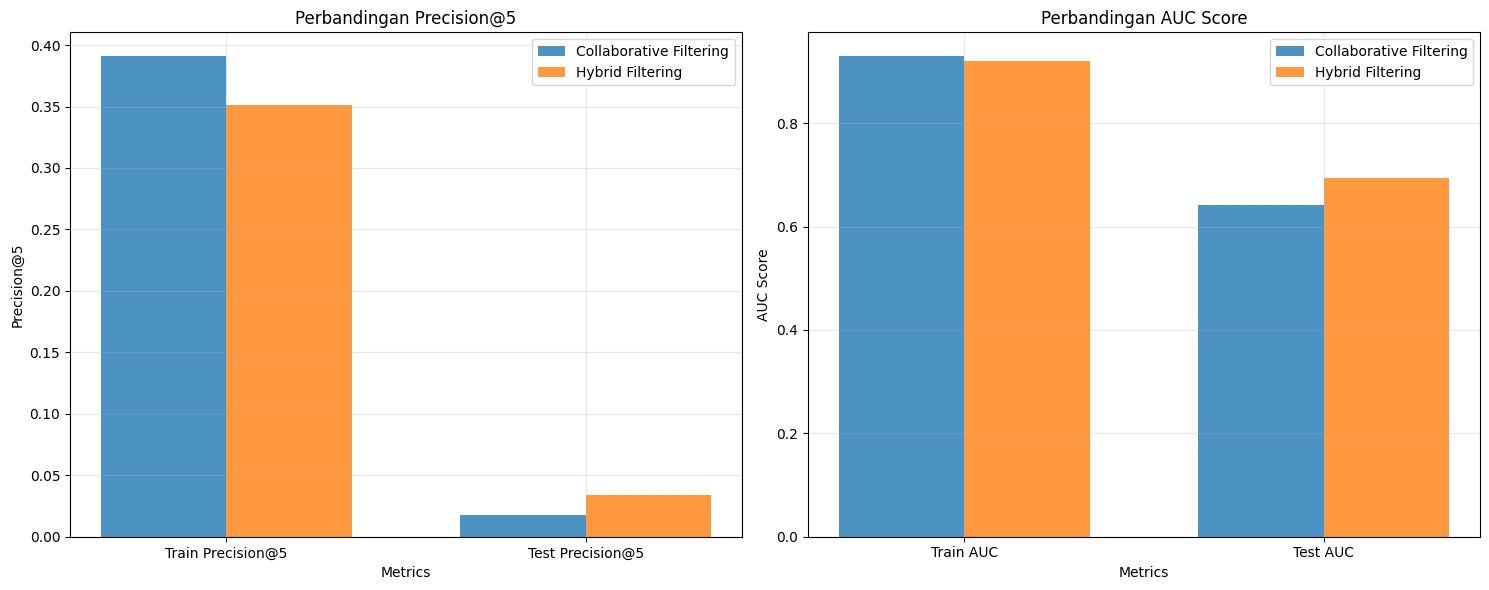

In [169]:
comparison_data = {
    'Model': ['Collaborative Filtering', 'Hybrid Filtering'],
    'Train Precision@5': [cf_results['train_precision'], hybrid_results['train_precision']],
    'Train AUC': [cf_results['train_auc'], hybrid_results['train_auc']],
    'Test Precision@5': [cf_results['test_precision'], hybrid_results['test_precision']],
    'Test AUC': [cf_results['test_auc'], hybrid_results['test_auc']]
}

comparison_df = pd.DataFrame(comparison_data)
print(" PERBANDINGAN PERFORMA MODEL:")
print(comparison_df.to_string(index=False, float_format='%.4f'))

# Tentukan model terbaik
if hybrid_results['test_precision'] > cf_results['test_precision']:
    best_model_name = 'Hybrid Filtering'
    best_model = hybrid_model
    best_test_precision = hybrid_results['test_precision']
    model_type = 'hybrid'
else:
    best_model_name = 'Collaborative Filtering'
    best_model = cf_model
    best_test_precision = cf_results['test_precision']
    model_type = 'collaborative'

print(f"\n🏆 MODEL TERBAIK: {best_model_name}")
print(f"📊 Test Precision@5: {best_test_precision:.4f}")

# ============================================================================
# CELL 20: Visualisasi Perbandingan Model
# ============================================================================

# Visualisasi perbandingan model
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot Precision@5
metrics = ['Train Precision@5', 'Test Precision@5']
cf_precision = [cf_results['train_precision'], cf_results['test_precision']]
hybrid_precision = [hybrid_results['train_precision'], hybrid_results['test_precision']]

x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, cf_precision, width, label='Collaborative Filtering', alpha=0.8)
axes[0].bar(x + width/2, hybrid_precision, width, label='Hybrid Filtering', alpha=0.8)
axes[0].set_xlabel('Metrics')
axes[0].set_ylabel('Precision@5')
axes[0].set_title('Perbandingan Precision@5')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot AUC Score
metrics_auc = ['Train AUC', 'Test AUC']
cf_auc = [cf_results['train_auc'], cf_results['test_auc']]
hybrid_auc = [hybrid_results['train_auc'], hybrid_results['test_auc']]

axes[1].bar(x - width/2, cf_auc, width, label='Collaborative Filtering', alpha=0.8)
axes[1].bar(x + width/2, hybrid_auc, width, label='Hybrid Filtering', alpha=0.8)
axes[1].set_xlabel('Metrics')
axes[1].set_ylabel('AUC Score')
axes[1].set_title('Perbandingan AUC Score')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics_auc)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [168]:
print("=" * 60)
print("SETUP UNTUK REKOMENDASI")
print("=" * 60)

# Buat mapping untuk konversi ID
user_mapping = {v: k for k, v in dataset.mapping()[0].items()}
item_mapping = {v: k for k, v in dataset.mapping()[2].items()}

print(f" User mapping berhasil dibuat ({len(user_mapping)} users)")
print(f" Item mapping berhasil dibuat ({len(item_mapping)} items)")

# Pilih sample user untuk demo
sample_users = df_ratings['User-ID'].unique()[:5]
print(f"\n👥 Sample Users untuk demo: {sample_users}")

SETUP UNTUK REKOMENDASI
 User mapping berhasil dibuat (460 users)
 Item mapping berhasil dibuat (515 items)

👥 Sample Users untuk demo: [277427 278418   2033   2110   2276]


In [167]:

# ============================================================================
# CELL 22: Rekomendasi dengan Collaborative Filtering
# ============================================================================

print("=" * 80)
print("REKOMENDASI DENGAN COLLABORATIVE FILTERING")
print("=" * 80)

# Pilih user untuk demo
demo_user_id = df_ratings['User-ID'].iloc[100]  # User ke-100
user_index = dataset.mapping()[0].get(demo_user_id)

print(f" REKOMENDASI UNTUK USER ID: {demo_user_id}")
print(f" Model: COLLABORATIVE FILTERING")
print("-" * 50)

# Generate predictions dengan Collaborative Filtering
cf_scores = cf_model.predict(user_index, np.arange(interactions.shape[1]))
cf_top_items = np.argsort(-cf_scores)[:5]
cf_recommended_isbns = [item_mapping[i] for i in cf_top_items]

# Tampilkan rekomendasi CF
print(" TOP 5 REKOMENDASI (COLLABORATIVE FILTERING):")
for i, isbn in enumerate(cf_recommended_isbns, 1):
    book_info = df_books[df_books['ISBN'] == isbn]
    if not book_info.empty:
        book = book_info.iloc[0]
        score = cf_scores[cf_top_items[i-1]]
        print(f"\n{i}. {book['Book-Title']}")
        print(f"    Author: {book['Book-Author']}")
        print(f"    Publisher: {book['Publisher']}")
        print(f"    Score: {score:.4f}")
        print(f"    ISBN: {isbn}")

        # Tampilkan gambar jika memungkinkan
        try:
            display(Image(url=book['Image-URL-L'], width=100))
        except:
            print(f"   🖼️  Image URL: {book['Image-URL-L']}")


REKOMENDASI DENGAN COLLABORATIVE FILTERING
 REKOMENDASI UNTUK USER ID: 6242
 Model: COLLABORATIVE FILTERING
--------------------------------------------------
 TOP 5 REKOMENDASI (COLLABORATIVE FILTERING):

1. The Lovely Bones: A Novel
    Author: Alice Sebold
    Publisher: Little, Brown
    Score: 0.7766
    ISBN: 0316666343



2. Bel Canto: A Novel
    Author: Ann Patchett
    Publisher: Perennial
    Score: -0.2370
    ISBN: 0060934417



3. The Bonesetter's Daughter
    Author: Amy Tan
    Publisher: Putnam Publishing Group
    Score: -0.5512
    ISBN: 0399146431



4. Tears of the Giraffe (No.1 Ladies Detective Agency)
    Author: Alexander McCall Smith
    Publisher: Anchor
    Score: -0.5700
    ISBN: 1400031354



5. Empire Falls
    Author: Richard Russo
    Publisher: Vintage Books USA
    Score: -0.8051
    ISBN: 0375726403


In [34]:
# ============================================================================
# CELL 23: Rekomendasi dengan Hybrid Filtering
# ============================================================================

print("=" * 80)
print("REKOMENDASI DENGAN HYBRID FILTERING")
print("=" * 80)

print(f"🔍 REKOMENDASI UNTUK USER ID: {demo_user_id}")
print(f"📊 Model: HYBRID FILTERING")
print("-" * 50)

hybrid_scores = hybrid_model.predict(
    user_index,
    np.arange(interactions.shape[1]),
    item_features=item_features
)
hybrid_top_items = np.argsort(-hybrid_scores)[:5]
hybrid_recommended_isbns = [item_mapping[i] for i in hybrid_top_items]

print("📚 TOP 5 REKOMENDASI (HYBRID FILTERING):")
for i, isbn in enumerate(hybrid_recommended_isbns, 1):
    book_info = df_books[df_books['ISBN'] == isbn]
    if not book_info.empty:
        book = book_info.iloc[0]
        score = hybrid_scores[hybrid_top_items[i-1]]
        print(f"\n{i}. {book['Book-Title']}")
        print(f"   Author: {book['Book-Author']}")
        print(f"   Publisher: {book['Publisher']}")
        print(f"   Score: {score:.4f}")
        print(f"   ISBN: {isbn}")

        # Tampilkan gambar jika memungkinkan
        try:
            display(Image(url=book['Image-URL-L'], width=100))
        except:
            print(f"   🖼️  Image URL: {book['Image-URL-L']}")

REKOMENDASI DENGAN HYBRID FILTERING
🔍 REKOMENDASI UNTUK USER ID: 2276
📊 Model: HYBRID FILTERING
--------------------------------------------------
📚 TOP 5 REKOMENDASI (HYBRID FILTERING):

1. The Partner
   Author: John Grisham
   Publisher: Dell Publishing Company
   Score: -0.0419
   ISBN: 0440224764



2. C Is for Corpse (Kinsey Millhone Mysteries (Paperback))
   Author: Sue Grafton
   Publisher: Bantam
   Score: -0.0860
   ISBN: 0553280368



3. Isle of Dogs
   Author: Patricia Cornwell
   Publisher: Berkley Publishing Group
   Score: -0.0949
   ISBN: 0425182908



4. Jack &amp; Jill (Alex Cross Novels)
   Author: James Patterson
   Publisher: Warner Books
   Score: -0.1616
   ISBN: 0446604801



5. 2nd Chance
   Author: James Patterson
   Publisher: Warner Vision
   Score: -0.1648
   ISBN: 0446612790
